<image src="https://raw.githubusercontent.com/ramiro999/structured-light/main/data/images/Banner Hands-on.png" width=100%>

# <font color="EB9A54"><center> **Hands-On Sesión 6: Imágenes de profundidad activa con luz estructurada 📷 🤖** </center></font>

## <font color='#4C5FDA'> **Contenido** <a name="tema1">

[**1. Motivación**](#tema1)

[**2. Calibración y rectificación**](#tema2)

[**3. Adquisión de patrones**](#tema3)

[**4. Captura de imagenes**](#tema4)

[**5. Disparidad**](#tema5)

[**6. Reeconstrucción 3D de profundidad**](#tema6)


# <font color="4C5FDA"> <center> **Motivación** </center> </font> <a name="tema1">


La <font color="4C5FDA"> **luz estructurada**</font> en visión por computadora es una tecnología fascinante que tiene el potencial de revolucionar numerosas industrias al proporcionar soluciones de medición y mapeo precisas. En un mundo donde la precisión y la eficiencia son cruciales, la luz estructurada ofrece una herramienta inigualable para capturar la geometría de objetos en 3D de manera rápida y precisa.

Te invito a que veas el proceso y lo pruebes por tu propia cuenta:

<div align="center"> <image src="https://raw.githubusercontent.com/ramiro999/structured-light/main/data/images/structured-light-pipeline.png" width=800>  </div>



In [1]:
#@title **Instalamos algunos paquetes**
!pip install tqdm opencv-contrib-python==4.8.0.74 pycolmap
!pip install open3d
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting 

In [2]:
#@title **Cargamos librerias**
import glob
import os
import cv2
import cv2.aruco as aruco
import skimage.transform
import numpy as np
from matplotlib import pyplot as plt
import h5py
import requests
import open3d as o3d
from open3d import geometry as o3dg
from google.colab.patches import cv2_imshow
import skimage.transform

In [3]:
#@title **Funciones necesarias**

def mostrar_imagenes(imagen_izquierda, imagen_derecha):

    imagen_izquierda = cv2.imread(imgL)
    imagen_derecha = cv2.imread(imgR)

    imagen_izquierda = cv2.cvtColor(imagen_izquierda, cv2.COLOR_BGR2RGB)
    imagen_derecha = cv2.cvtColor(imagen_derecha, cv2.COLOR_BGR2RGB)

    # Configura el tamaño del plot
    plt.figure(figsize=(15, 9))

    # Muestra la imagen izquierda
    plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, posición 1
    plt.imshow(imagen_izquierda , cmap='gray')
    plt.title('Imagen Izquierda')  # Agrega un título a la primera imagen
    plt.axis('off')  # Oculta los ejes

    # Muestra la imagen derecha
    plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, posición 2
    plt.imshow(imagen_derecha, cmap='gray')
    plt.title('Imagen Derecha')  # Agrega un título a la segunda imagen
    plt.axis('off')  # Oculta los ejes

    # Muestra el plot con ambas imágenes
    plt.show()

def descargar_contenido_github(url, path_local):
    """
    Función recursiva para descargar archivos y subcarpetas desde un repositorio de GitHub.
    """
    # Obtener la lista de archivos y carpetas en la URL dada
    response = requests.get(url)
    contents = response.json()

    # Verificar si el path local existe, si no, crearlo
    os.makedirs(path_local, exist_ok=True)

    # Iterar sobre cada elemento en la carpeta
    for item in contents:
        if item['type'] == 'file':
            # Es un archivo, descargarlo
            download_url = item['download_url']
            file_response = requests.get(download_url)
            file_path = os.path.join(path_local, item['name'])
            with open(file_path, 'wb') as file:
                file.write(file_response.content)
            #print(f"Descargado: {file_path}")
        elif item['type'] == 'dir':
            # Es un directorio, realizar una llamada recursiva
            new_path_local = os.path.join(path_local, item['name'])
            new_url = item['url']
            descargar_contenido_github(new_url, new_path_local)

# URL inicial de la API para la carpeta específica
url_inicial = "https://api.github.com/repos/semilleroCV/Hands-on-Computer-Vision/contents/Sesiones/Sesion6/Parte-1/data"
path_inicial = "data"

# Iniciar la descarga
descargar_contenido_github(url_inicial, path_inicial)



## <font color='#EB9A54'>**Calibración y Rectificación**</font> <a name="tema2">

Charuco es un tipo de tablero de calibración que combina un tablero de ajedrez con marcadores ArUco. Este tipo de tablero ofrece varias ventajas para la calibración de cámaras y la estimación de la pose:

1. <font color="4C5FDA"> **Precisión**: </font> Los tableros Charuco pueden proporcionar una calibración más precisa que los tableros de ajedrez tradicionales. Esto se debe a que los marcadores ArUco permiten una detección de esquinas más precisa.

2. <font color="4C5FDA"> **Robustez**: </font> Los tableros Charuco son más robustos a las oclusiones y a las condiciones de iluminación difíciles. Incluso si algunos de los marcadores ArUco no se pueden detectar, todavía es posible utilizar el tablero para la calibración.

3. <font color="4C5FDA"> **Flexibilidad**: </font> Los tableros Charuco son flexibles en términos de tamaño y configuración. Puedes ajustar el número de cuadrados y marcadores ArUco según tus necesidades.

4. <font color="4C5FDA"> **Rapidez**: </font> La detección de tableros Charuco es generalmente más rápida que la detección de tableros de ajedrez tradicionales.

Por estas razones, si estás trabajando en un proyecto que requiere la calibración de cámaras o la estimación de la pose, un tablero Charuco puede ser una excelente opción.

<div align="center"> <image src="https://raw.githubusercontent.com/ramiro999/structured-light/main/data/images/charuco.png" width=800>  </div>


Ahora bien, haciendo uso de funciones como `Dictionary_get` para la colección de patrones de marcadores que el módulo ArUco puede reconocer y decodificar.  y `CharucoBoard` para definir el número de cuadrados en X e Y, el tamaño de los cuadrados, el tamaño de los marcadores ArUco, y el diccionario de marcadores, como tambien `detectMarkers` , `refineDetectedMarkers` `interpolateCornersCharuco`, `drawDetectedCornernsCharuco` para detectar, refinar, interporlar las esquinas y finalmente dibujar las esquinas y los IDs de charuco detectados en una imagen.

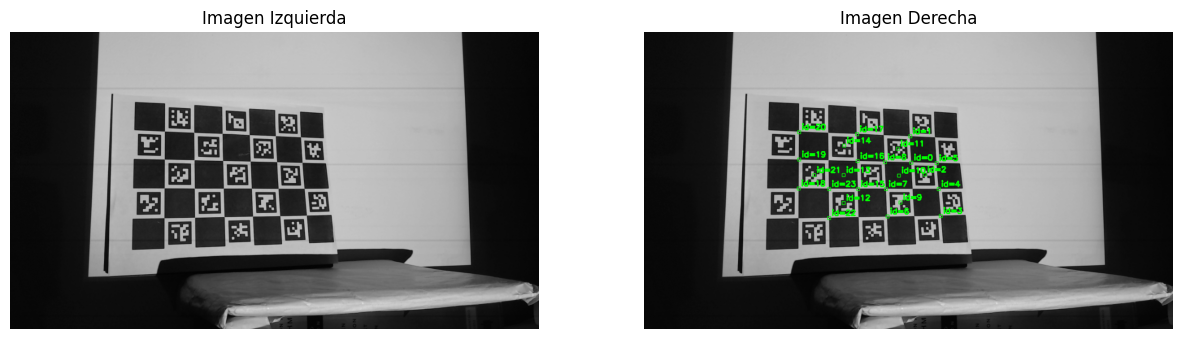

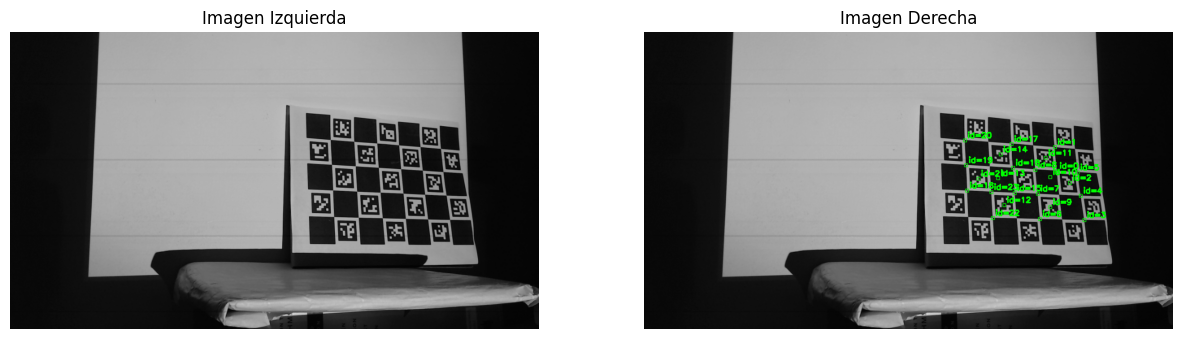

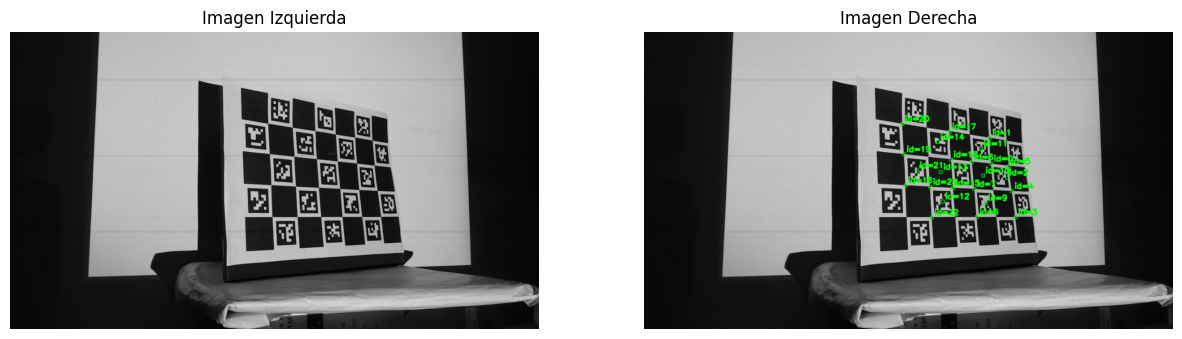

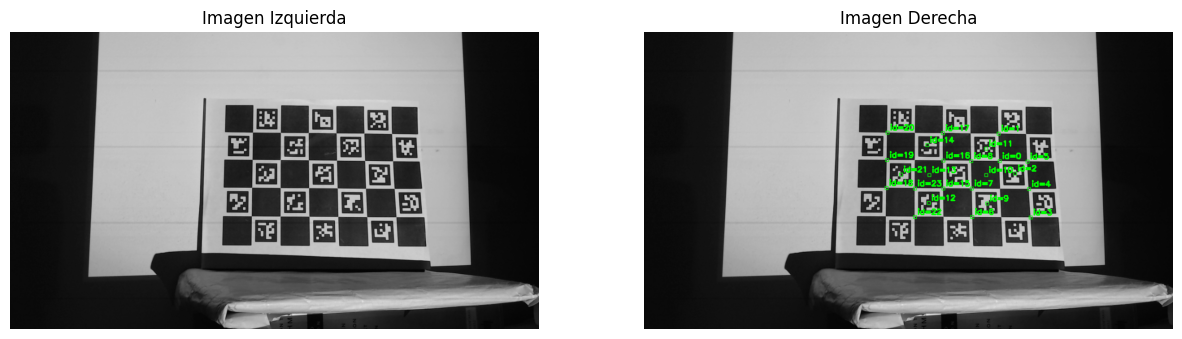

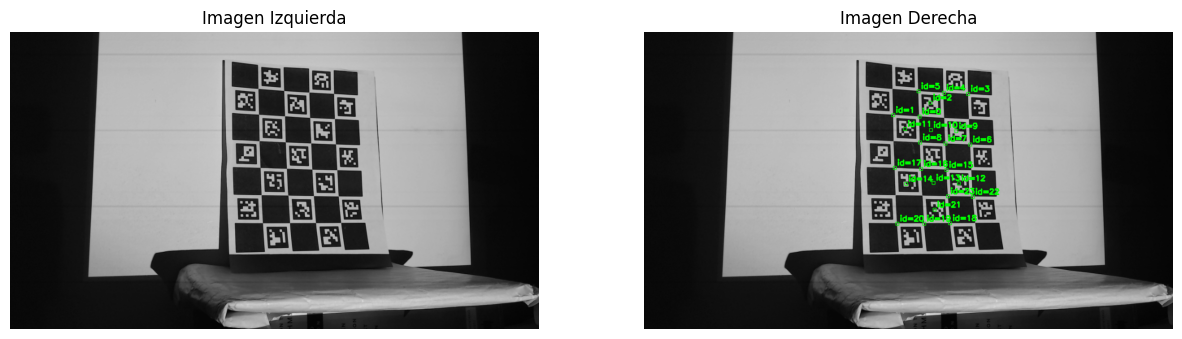

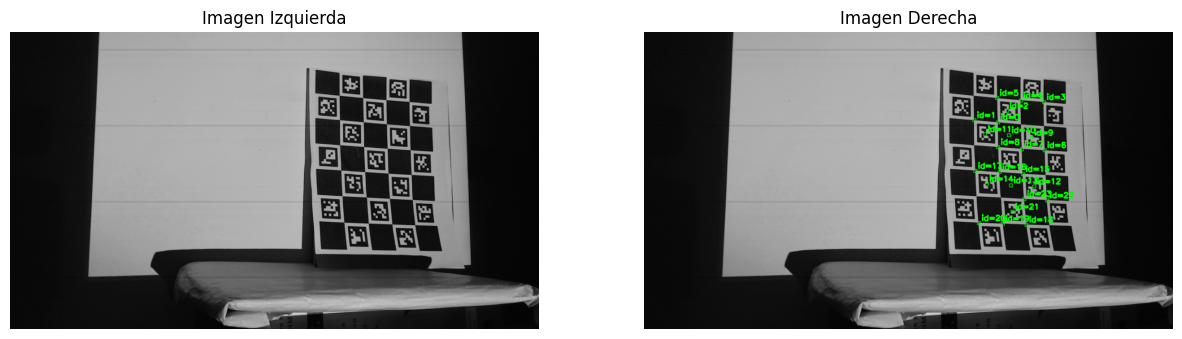

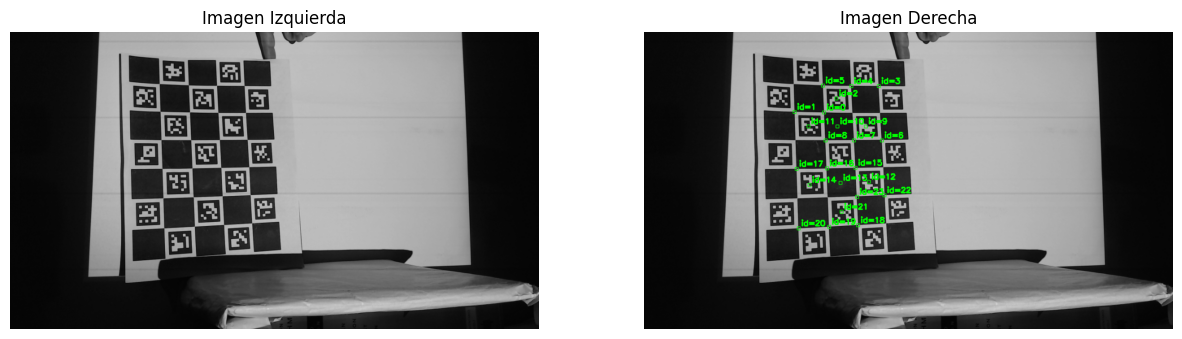

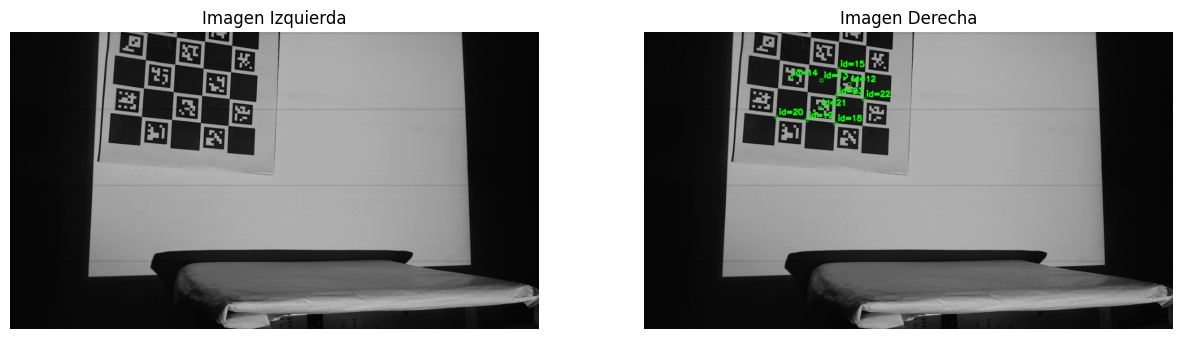

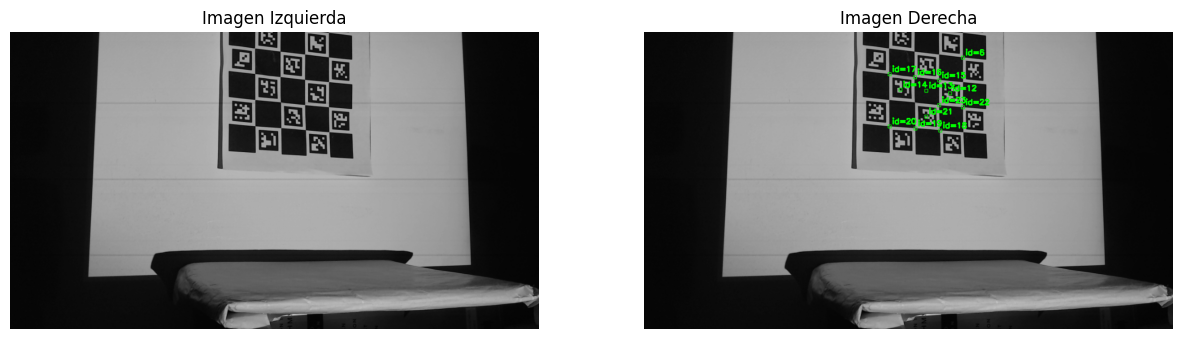

In [4]:
for i in range(10):
  imgL = f"data/charuco/left/{i}.png"
  imgR = f"data/charuco_corners/left/{i}.png"
  if os.path.isfile(imgL):
    mostrar_imagenes(imgL, imgR)

## <font color='#EB9A54'>**Adquisión de patrones**</font> <a name="tema3">

Antes de adquirir las imagenes del objeto debemos conocer los patrones que se proyectaran ante el objeto, en la identificación de patrones contaremos con un patrón de franjas estacionarias de manera vertical y horizontal.

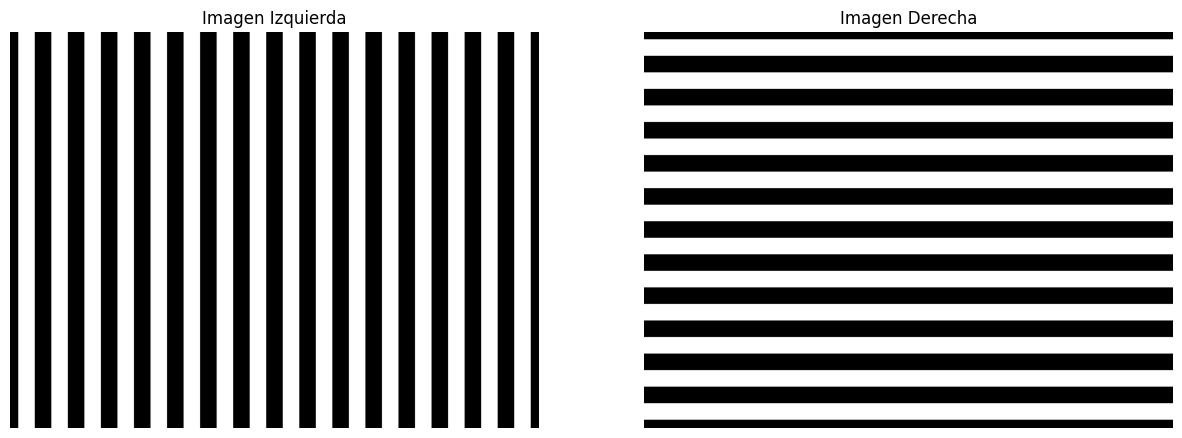

In [5]:
imgL = "data/patterns/pattern_10.png"
imgR = "data/patterns/pattern_30.png"
mostrar_imagenes(imgL, imgR)

## <font color='#EB9A54'>**Captura de imagenes**</font> <a name="tema4">

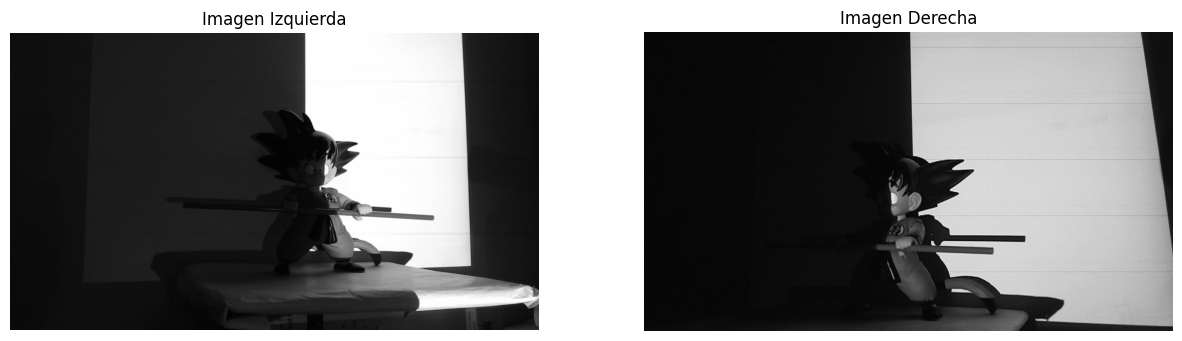

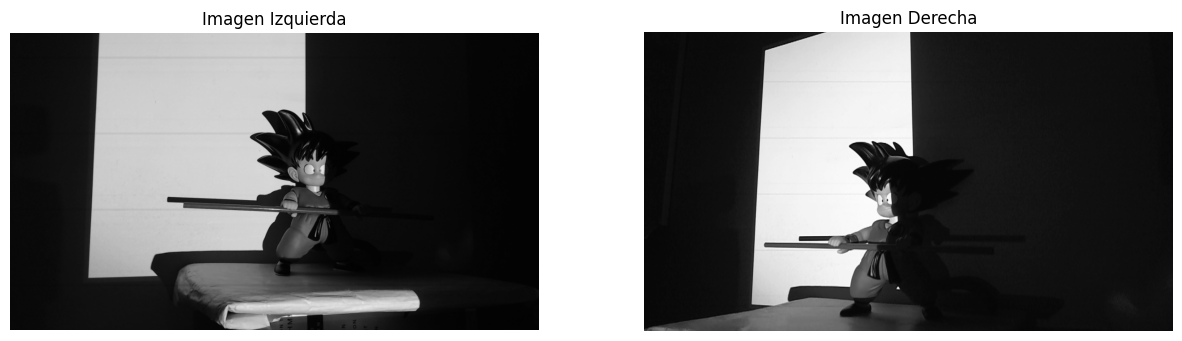

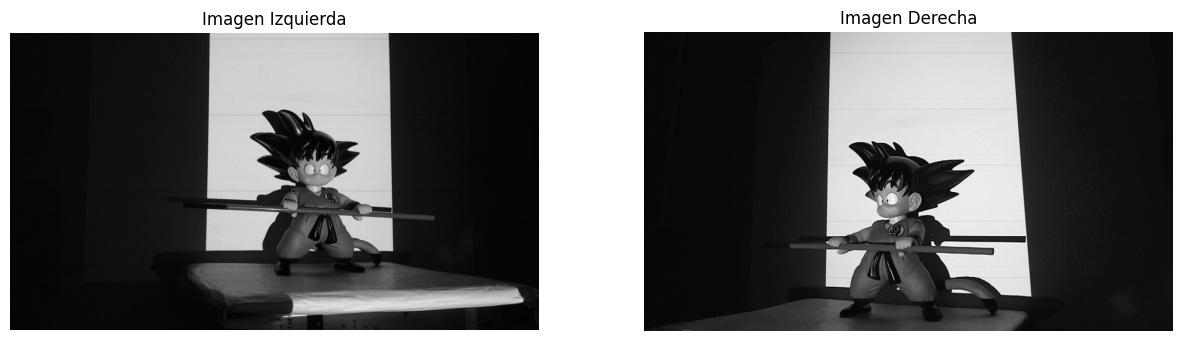

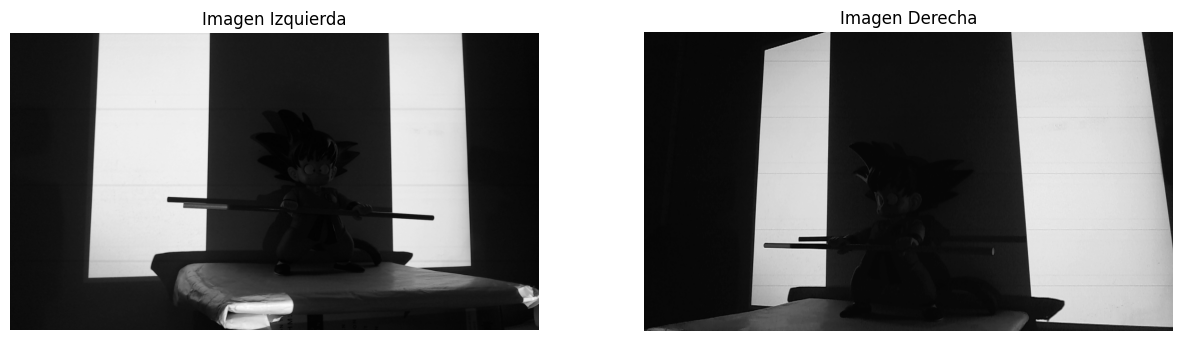

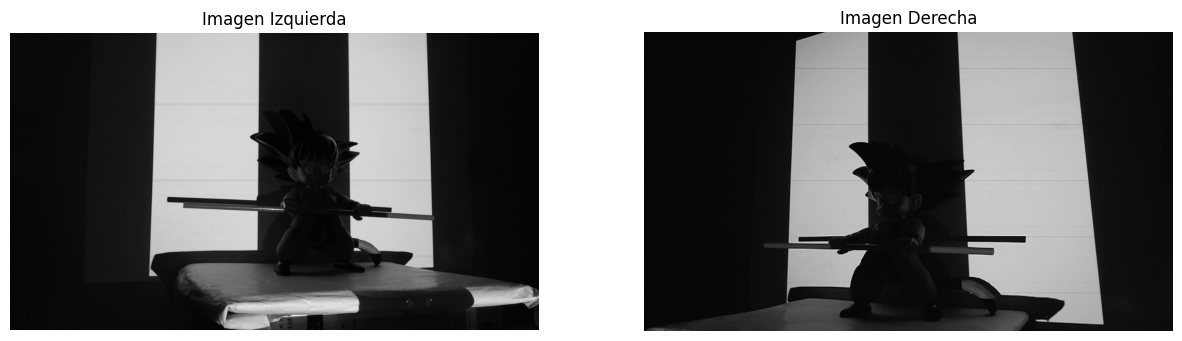

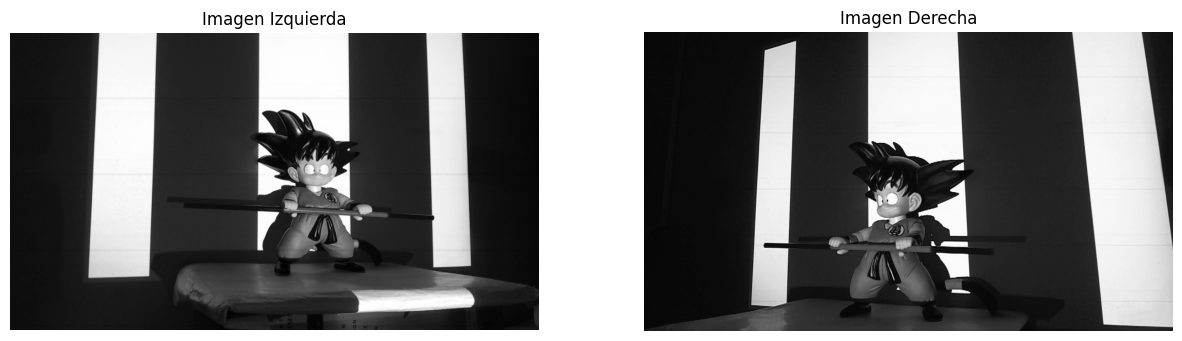

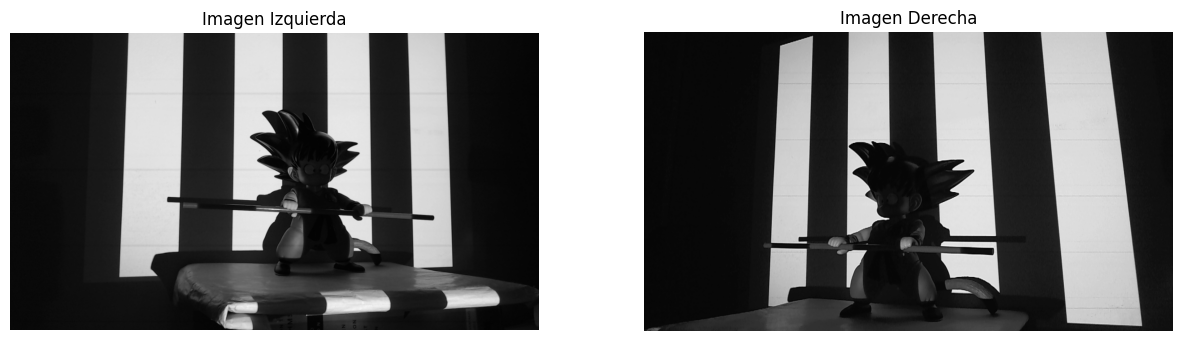

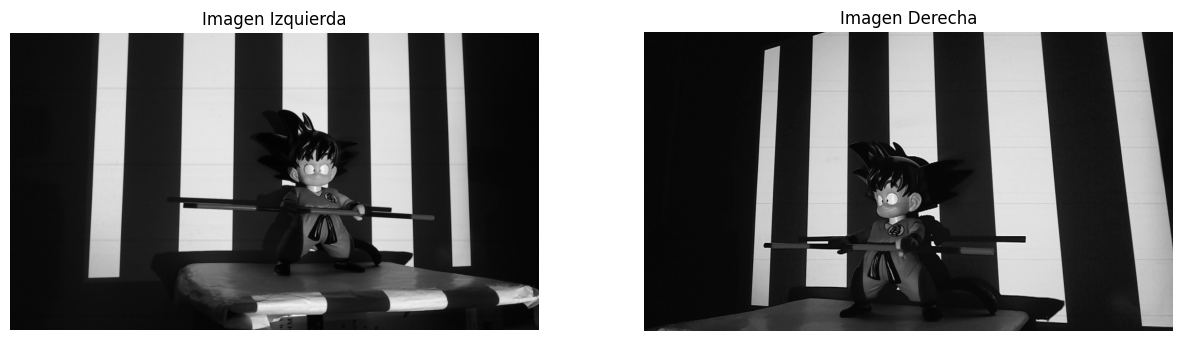

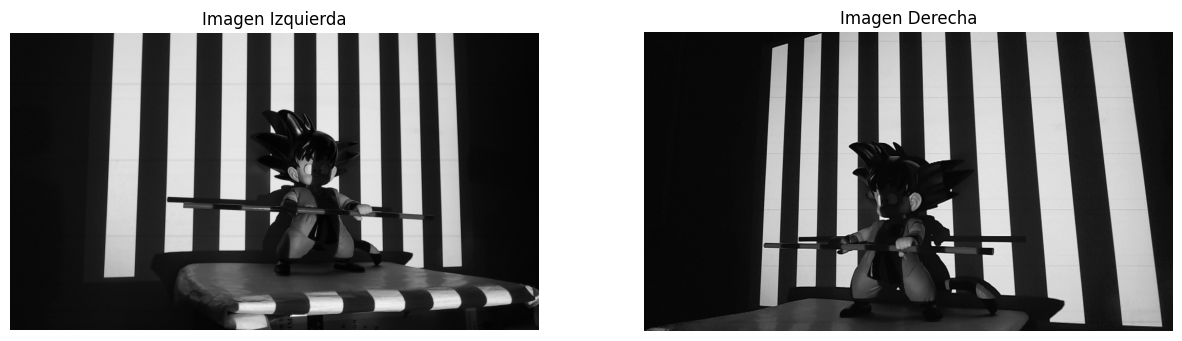

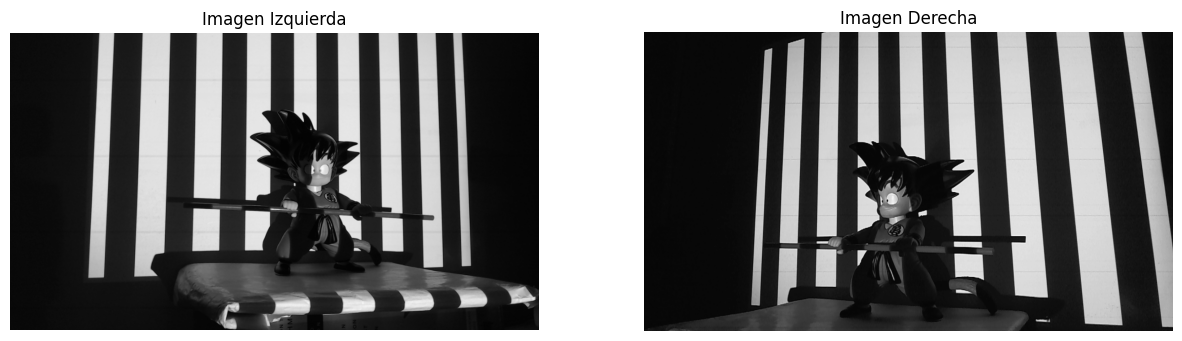

In [6]:
for i in range(10):
  imgL = f"data/goku/left/{i}.png"
  imgR = f"data/goku/right/{i}.png"
  mostrar_imagenes(imgL, imgR)

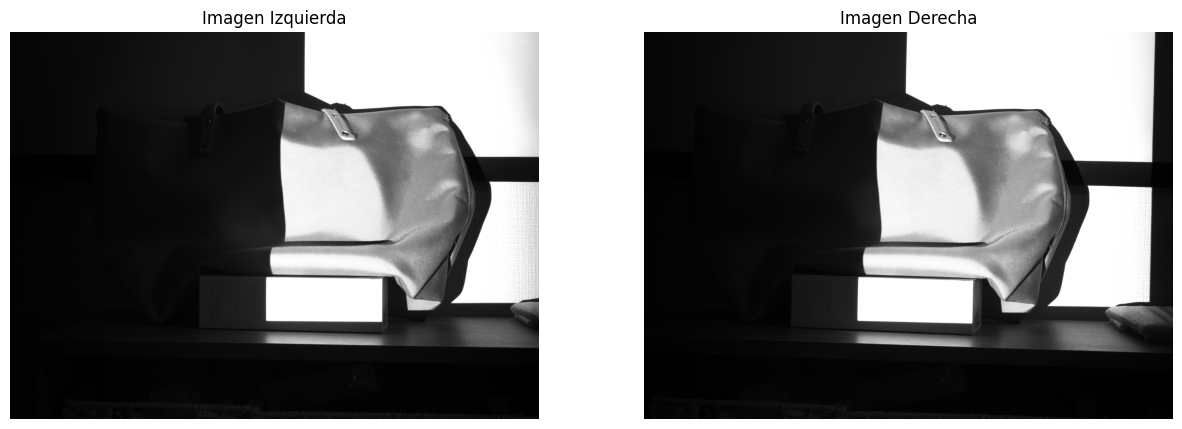

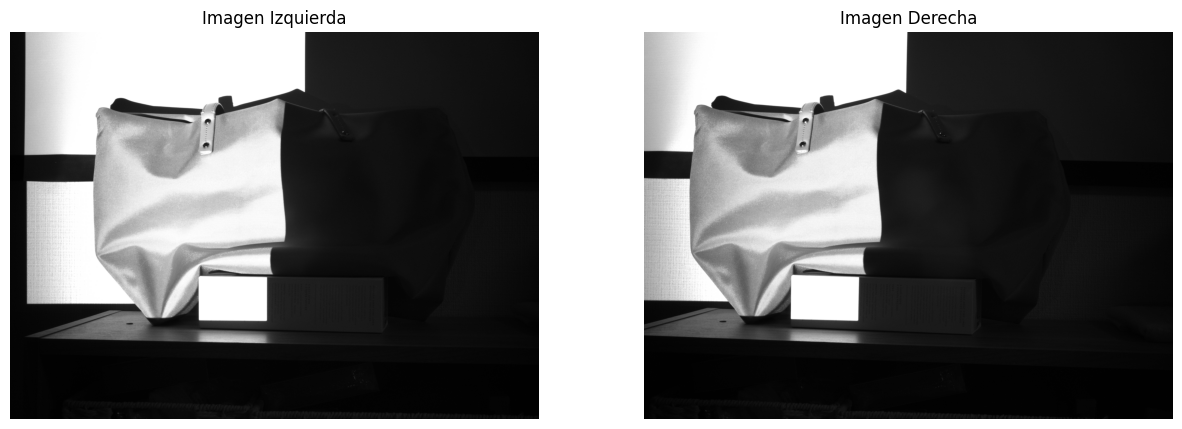

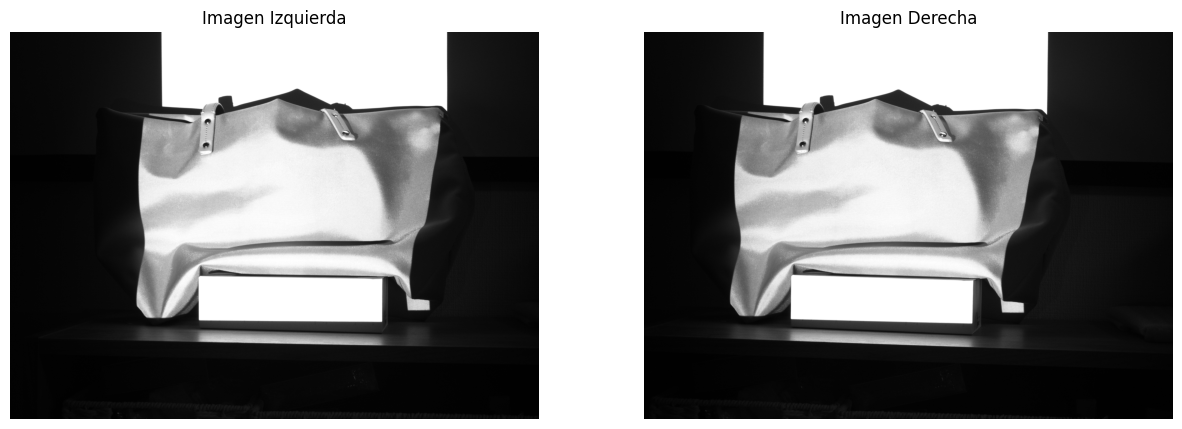

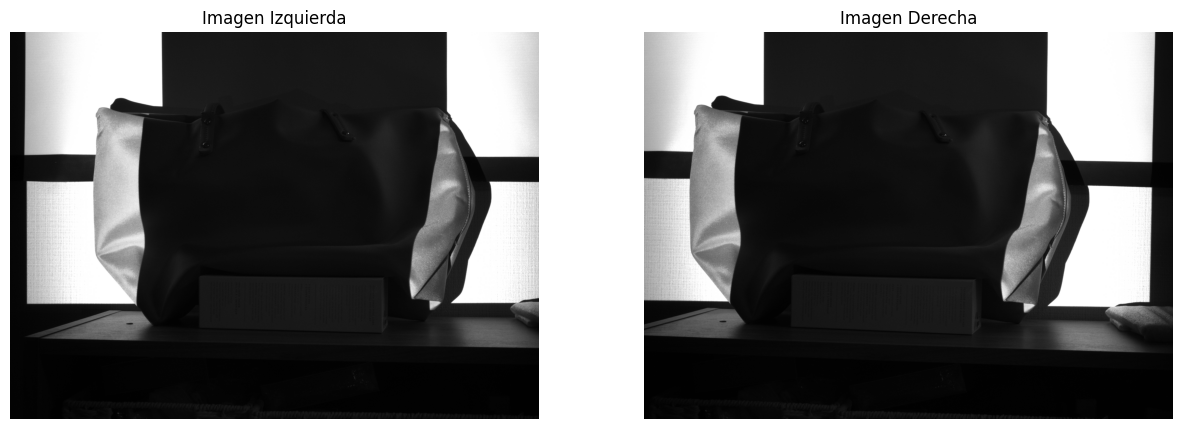

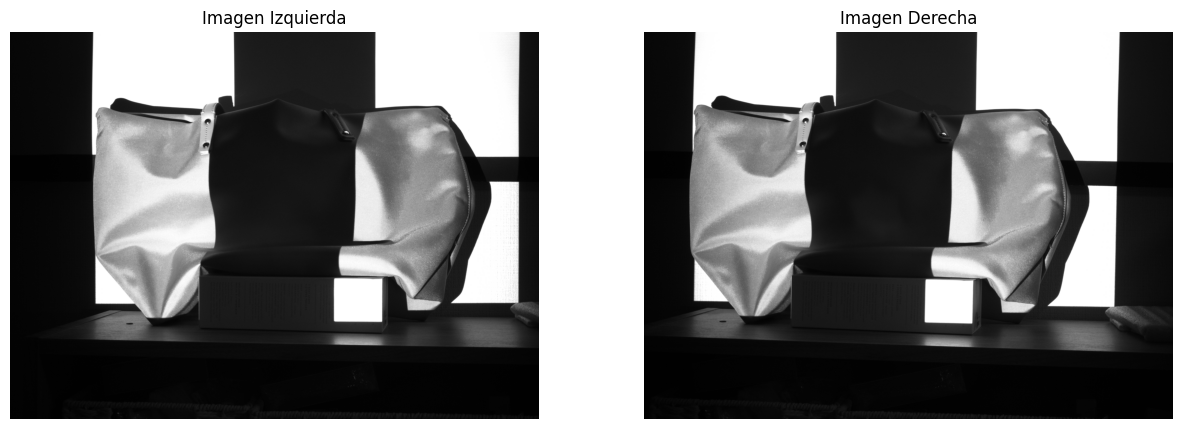

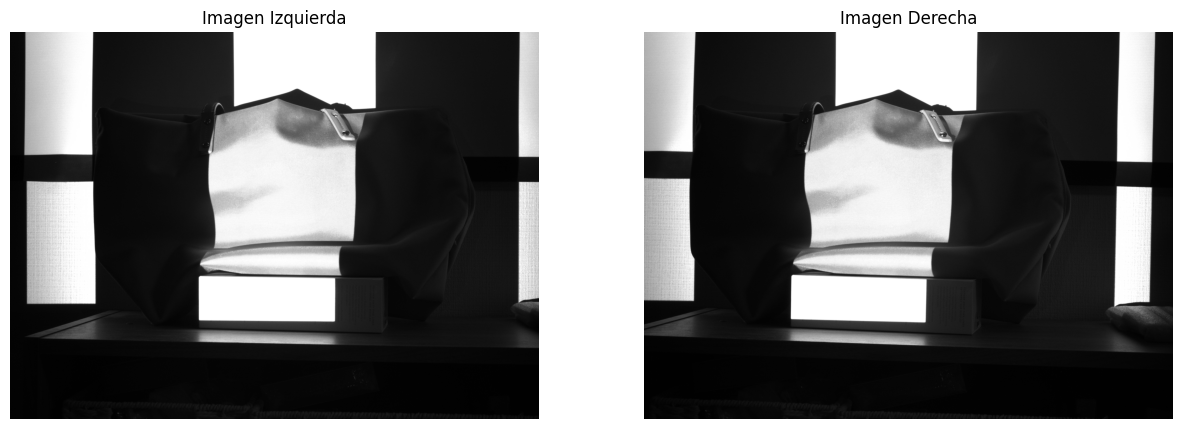

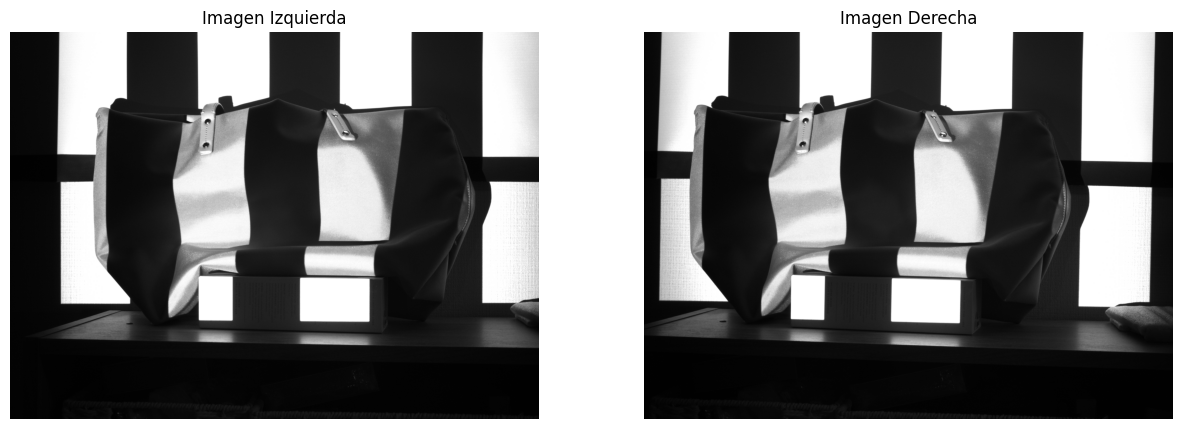

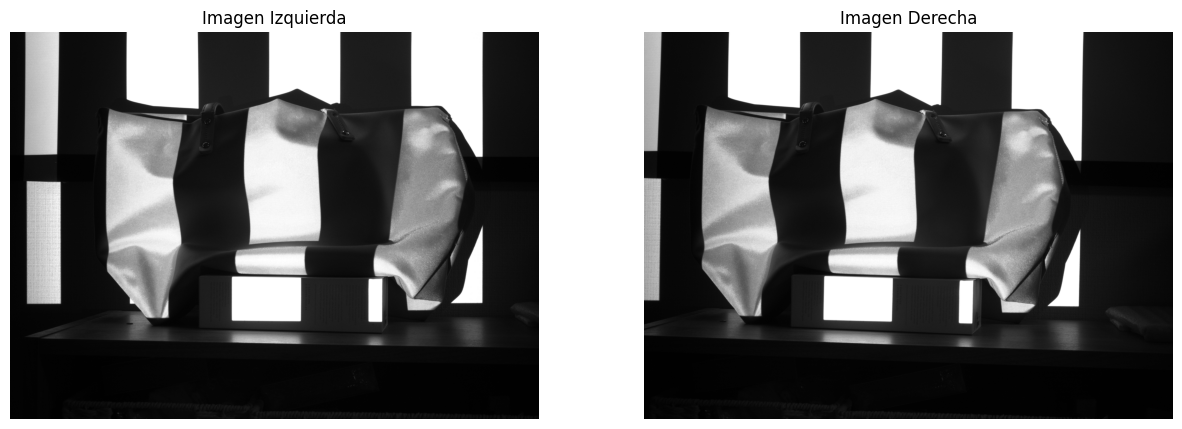

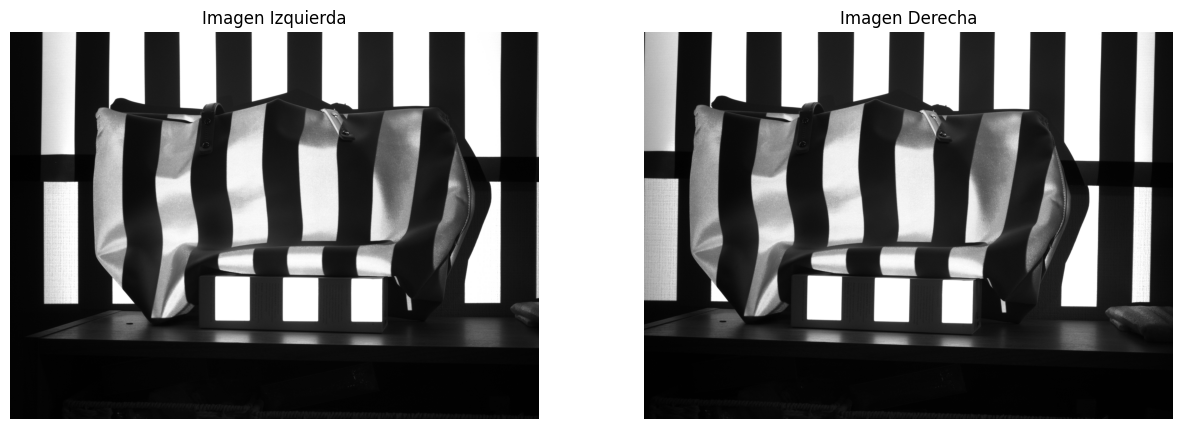

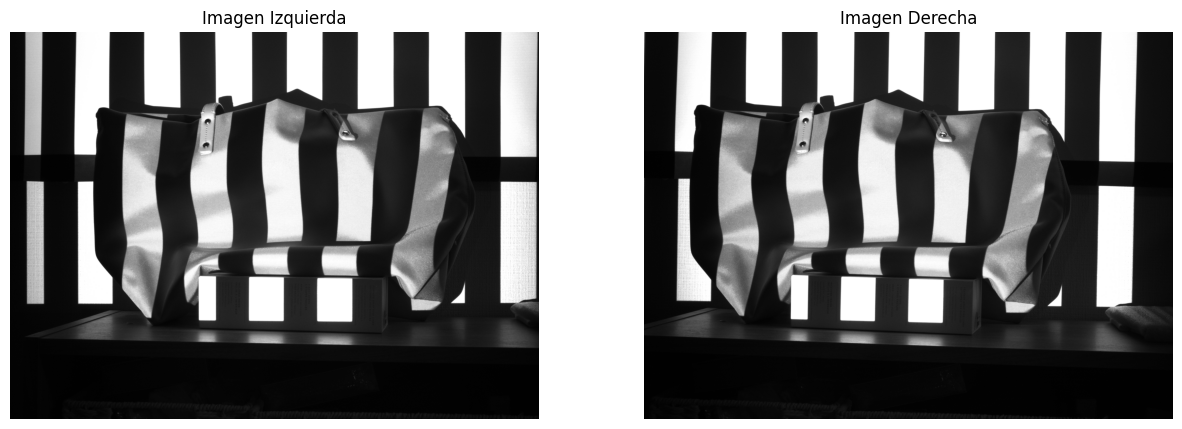

In [7]:
for i in range(10):
  imgL = f"data/bag/left/{i}.png"
  imgR = f"data/bag/right/{i}.png"
  mostrar_imagenes(imgL, imgR)

In [8]:
# Función para convertir arrays representado un punto de nube en un objeto PointCloud
def numpy_to_o3d(pcd_np):
    valid_ids = (~np.isnan(pcd_np).any(axis=1)) * (~np.isinf(pcd_np).any(axis=1))
    valid_pcd = pcd_np[valid_ids]
    print('there are {} points'.format(valid_pcd.shape[0]))
    tmp = o3dg.PointCloud()
    tmp.points = o3d.utility.Vector3dVector(valid_pcd)
    return tmp

# Función carga el archivo de los datos de calibración.
def load_h5py_to_dict(data_dir):
    res = {}
    calib_data_h5 = h5py.File(data_dir, 'r')
    for k, v in calib_data_h5.items():
        res[k] = np.array(v)
    return res

# Función para generar la rectificación de los datos.
def generate_rectify_data(calib_data, size):
    M1, M2, d1, d2 = calib_data['M1'], calib_data['M2'], calib_data['d1'], calib_data['d2']
    R, t = calib_data['R'], calib_data['t']
    flag = cv2.CALIB_ZERO_DISPARITY
    R1, R2, P1, P2, Q = cv2.stereoRectify(cameraMatrix1=M1, cameraMatrix2=M2, distCoeffs1=d1, distCoeffs2=d2, R=R, T=t,
                                          flags=flag, alpha=-1, imageSize=size, newImageSize=size)[0:5]
    map_x_l, map_y_l = cv2.initUndistortRectifyMap(M1, d1, R1, P1, size, cv2.CV_32FC1)
    map_x_r, map_y_r = cv2.initUndistortRectifyMap(M2, d2, R2, P2, size, cv2.CV_32FC1)
    return map_x_l, map_y_l, map_x_r, map_y_r, P1, P2, Q

# Función para realizar la rectificación.
def rectify(img, map_x, map_y):
    res = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    return res


## <font color='#EB9A54'>**Disparidad**</font> <a name="tema5">

El numero de imagenes es 44


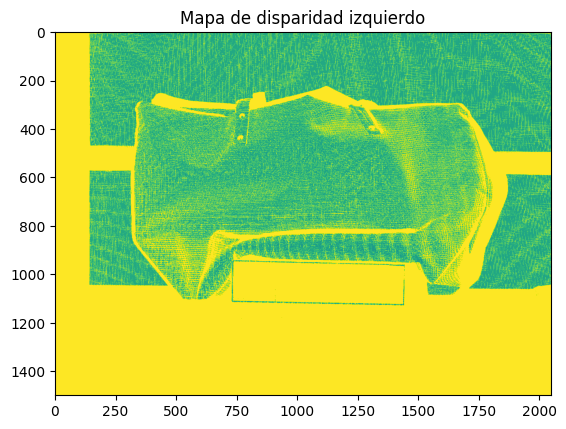

there are 1263043 points


True

In [9]:
# Parametros
proj_w, proj_h = 1920, 1080  # resolución del proyector.
white_thred, black_thred = 5, 40  # white-thred para decodificacion, black_thred for detección de sombreado blanco-negro.
img_size = (2048, 1500) #2048 y 1500
img_dir = 'data/bag'
calib_data_dir = 'data/stereo_calib_flir/stereo_calib_data.h5' # Cargamos los datos de calibración

# Cargar datos de la camara
calib_data = load_h5py_to_dict(calib_data_dir)
map_x_l, map_y_l, map_x_r, map_y_r, P1, P2, Q = generate_rectify_data(calib_data, size=img_size)

# Decodificador
graycode = cv2.structured_light_GrayCodePattern.create(width=proj_w, height=proj_h)
graycode.setWhiteThreshold(white_thred)
graycode.setBlackThreshold(black_thred)
num_required_imgs = graycode.getNumberOfPatternImages()
print('El numero de imagenes es {}'.format(num_required_imgs))

# Cargar data y rectificar:
rect_list_l, rect_list_r = [], []
for i in range(num_required_imgs + 2):
    img_l = cv2.imread(os.path.join(img_dir, './left/{}.png'.format(i)), 0)
    img_r = cv2.imread(os.path.join(img_dir, './right/{}.png'.format(i)), 0)
    l_rect, r_rect = rectify(img_l, map_x_l, map_y_l), rectify(img_r, map_x_r, map_y_r)
    plt.imshow(skimage.transform.rescale(np.concatenate([l_rect, r_rect], axis=1), 0.2))
    rect_list_l.append(l_rect)
    rect_list_r.append(r_rect)

# Decodificar
pattern_list = np.array([rect_list_l[:-2], rect_list_r[:-2]])
white_list = np.array([rect_list_l[-2], rect_list_r[-2]])
black_list = np.array([rect_list_l[-1], rect_list_r[-1]])
ret, disp_l = graycode.decode(pattern_list, np.zeros_like(pattern_list[0]), black_list, white_list)
ret, disp_r = graycode.decode(pattern_list, np.zeros_like(pattern_list[0]), black_list, white_list)

plt.imshow(disp_l)
plt.title('Mapa de disparidad izquierdo')
plt.show()

# De disparidad a procesamiento de nube de puntos.
cam_pts_l, cam_pts_r = [], []
for i in range(disp_l.shape[0]):
    for j in range(disp_l.shape[1]):
        if disp_l[i, j] != 0:
            cam_pts_l.append([j, i])
            cam_pts_r.append([j + disp_l[i, j], i])
cam_pts_l, cam_pts_r = np.array(cam_pts_l)[:, np.newaxis, :], np.array(cam_pts_r)[:, np.newaxis, :]
pts4D = cv2.triangulatePoints(P1, P2, np.float32(cam_pts_l), np.float32(cam_pts_r)).T
pts3D = pts4D[:, :3] / pts4D[:, -1:]

# Guardad nube de puntos.
tmp = numpy_to_o3d(pts3D)
cl, ind = tmp.remove_statistical_outlier(nb_neighbors=10, std_ratio=0.5)
tmp = tmp.select_by_index(ind)
o3d.io.write_point_cloud('./pcd.ply', tmp)

## <font color='#EB9A54'>**Reconstrucción 3D en profundidad**</font> <a name="*tema6*">

PointCloud with 1219820 points.


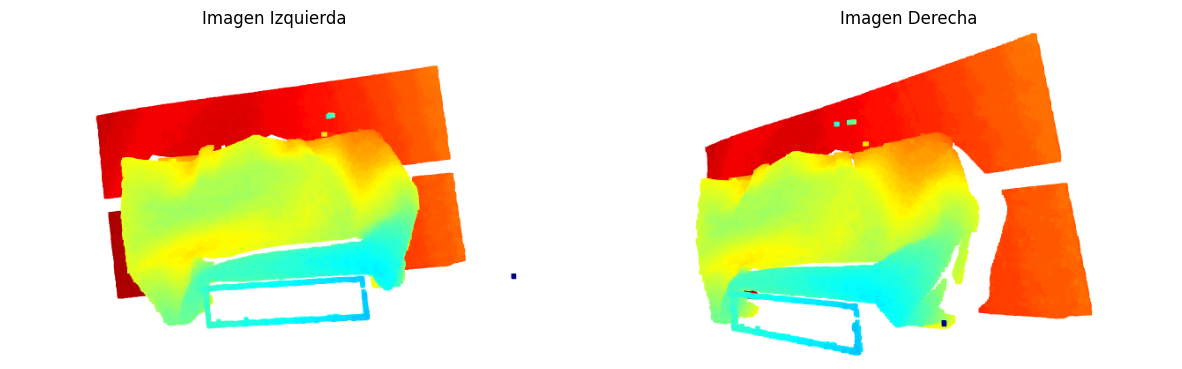

In [10]:
pcd = o3d.io.read_point_cloud('pcd.ply')
print(pcd)

imgL = "data/images/point-cloud-1.png"
imgR = "data/images/point-cloud-2.png"
mostrar_imagenes(imgL, imgR)

